# Sparse Matrix Operations

## Introduction

Sparse matrices are matrices in which most elements are zero. They arise naturally in numerous scientific and engineering applications, including:

- Finite element analysis
- Graph algorithms and network analysis
- Natural language processing (term-document matrices)
- Recommendation systems
- Solution of partial differential equations

## Mathematical Background

### Definition

A matrix $\mathbf{A} \in \mathbb{R}^{m \times n}$ is considered **sparse** if the number of non-zero elements $\text{nnz}(\mathbf{A})$ satisfies:

$$\text{nnz}(\mathbf{A}) \ll m \times n$$

The **sparsity** of a matrix is defined as:

$$\text{sparsity} = 1 - \frac{\text{nnz}(\mathbf{A})}{m \times n}$$

### Storage Formats

#### Compressed Sparse Row (CSR) Format

The CSR format stores a sparse matrix using three arrays:

1. **data**: Contains all non-zero values
2. **indices**: Column indices of non-zero values
3. **indptr**: Index pointers that delimit rows

For row $i$, the non-zero elements are stored in:
$$\texttt{data}[\texttt{indptr}[i]:\texttt{indptr}[i+1]]$$

#### Compressed Sparse Column (CSC) Format

Similar to CSR, but compressed by columns instead of rows. Efficient for column slicing and arithmetic operations.

### Computational Complexity

For a sparse matrix with $k$ non-zero elements:

| Operation | Dense | Sparse |
|-----------|-------|--------|
| Storage | $O(mn)$ | $O(k)$ |
| Matrix-vector product | $O(mn)$ | $O(k)$ |
| Matrix addition | $O(mn)$ | $O(k_1 + k_2)$ |

## Key Operations

### Sparse Matrix-Vector Multiplication

Given sparse matrix $\mathbf{A}$ and dense vector $\mathbf{x}$, the product $\mathbf{y} = \mathbf{A}\mathbf{x}$ is computed as:

$$y_i = \sum_{j: A_{ij} \neq 0} A_{ij} x_j$$

### Sparse Linear Systems

Solving $\mathbf{A}\mathbf{x} = \mathbf{b}$ where $\mathbf{A}$ is sparse typically uses iterative methods like:

- Conjugate Gradient (for symmetric positive definite matrices)
- GMRES (for general matrices)
- BiCGSTAB (for non-symmetric matrices)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import linalg as splinalg
import time

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully")

Libraries imported successfully


## Creating Sparse Matrices

We'll demonstrate various methods for creating sparse matrices and explore their internal structure.

In [2]:
# Create a sparse matrix from dense array
dense_matrix = np.array([
    [1, 0, 0, 2],
    [0, 0, 3, 0],
    [4, 0, 5, 0],
    [0, 6, 0, 0]
])

# Convert to CSR format
csr_matrix = sparse.csr_matrix(dense_matrix)

print("Original Dense Matrix:")
print(dense_matrix)
print(f"\nCSR Representation:")
print(f"  data:    {csr_matrix.data}")
print(f"  indices: {csr_matrix.indices}")
print(f"  indptr:  {csr_matrix.indptr}")
print(f"\nSparsity: {1 - csr_matrix.nnz / (csr_matrix.shape[0] * csr_matrix.shape[1]):.2%}")

Original Dense Matrix:
[[1 0 0 2]
 [0 0 3 0]
 [4 0 5 0]
 [0 6 0 0]]

CSR Representation:
  data:    [1 2 3 4 5 6]
  indices: [0 3 2 0 2 1]
  indptr:  [0 2 3 5 6]

Sparsity: 62.50%


## Generating Random Sparse Matrices

For testing and benchmarking, we often need to generate random sparse matrices with controlled density.

In [3]:
# Generate random sparse matrices of varying sizes and densities
n = 1000  # Matrix dimension
densities = [0.001, 0.01, 0.05, 0.1]

print(f"Random sparse matrices of size {n}x{n}:\n")
for density in densities:
    A = sparse.random(n, n, density=density, format='csr')
    memory_sparse = A.data.nbytes + A.indices.nbytes + A.indptr.nbytes
    memory_dense = n * n * 8  # 8 bytes per float64
    
    print(f"Density: {density:.1%}")
    print(f"  Non-zeros: {A.nnz:,}")
    print(f"  Sparse memory: {memory_sparse/1024:.1f} KB")
    print(f"  Dense memory:  {memory_dense/1024:.1f} KB")
    print(f"  Compression ratio: {memory_dense/memory_sparse:.1f}x\n")

Random sparse matrices of size 1000x1000:

Density: 0.1%
  Non-zeros: 1,000
  Sparse memory: 15.6 KB
  Dense memory:  7812.5 KB
  Compression ratio: 499.9x

Density: 1.0%
  Non-zeros: 10,000
  Sparse memory: 121.1 KB
  Dense memory:  7812.5 KB
  Compression ratio: 64.5x

Density: 5.0%
  Non-zeros: 50,000
  Sparse memory: 589.8 KB
  Dense memory:  7812.5 KB
  Compression ratio: 13.2x

Density: 10.0%
  Non-zeros: 100,000
  Sparse memory: 1175.8 KB
  Dense memory:  7812.5 KB
  Compression ratio: 6.6x



## Common Sparse Matrix Patterns

Many scientific applications produce matrices with specific sparsity patterns. Let's examine some common structures.

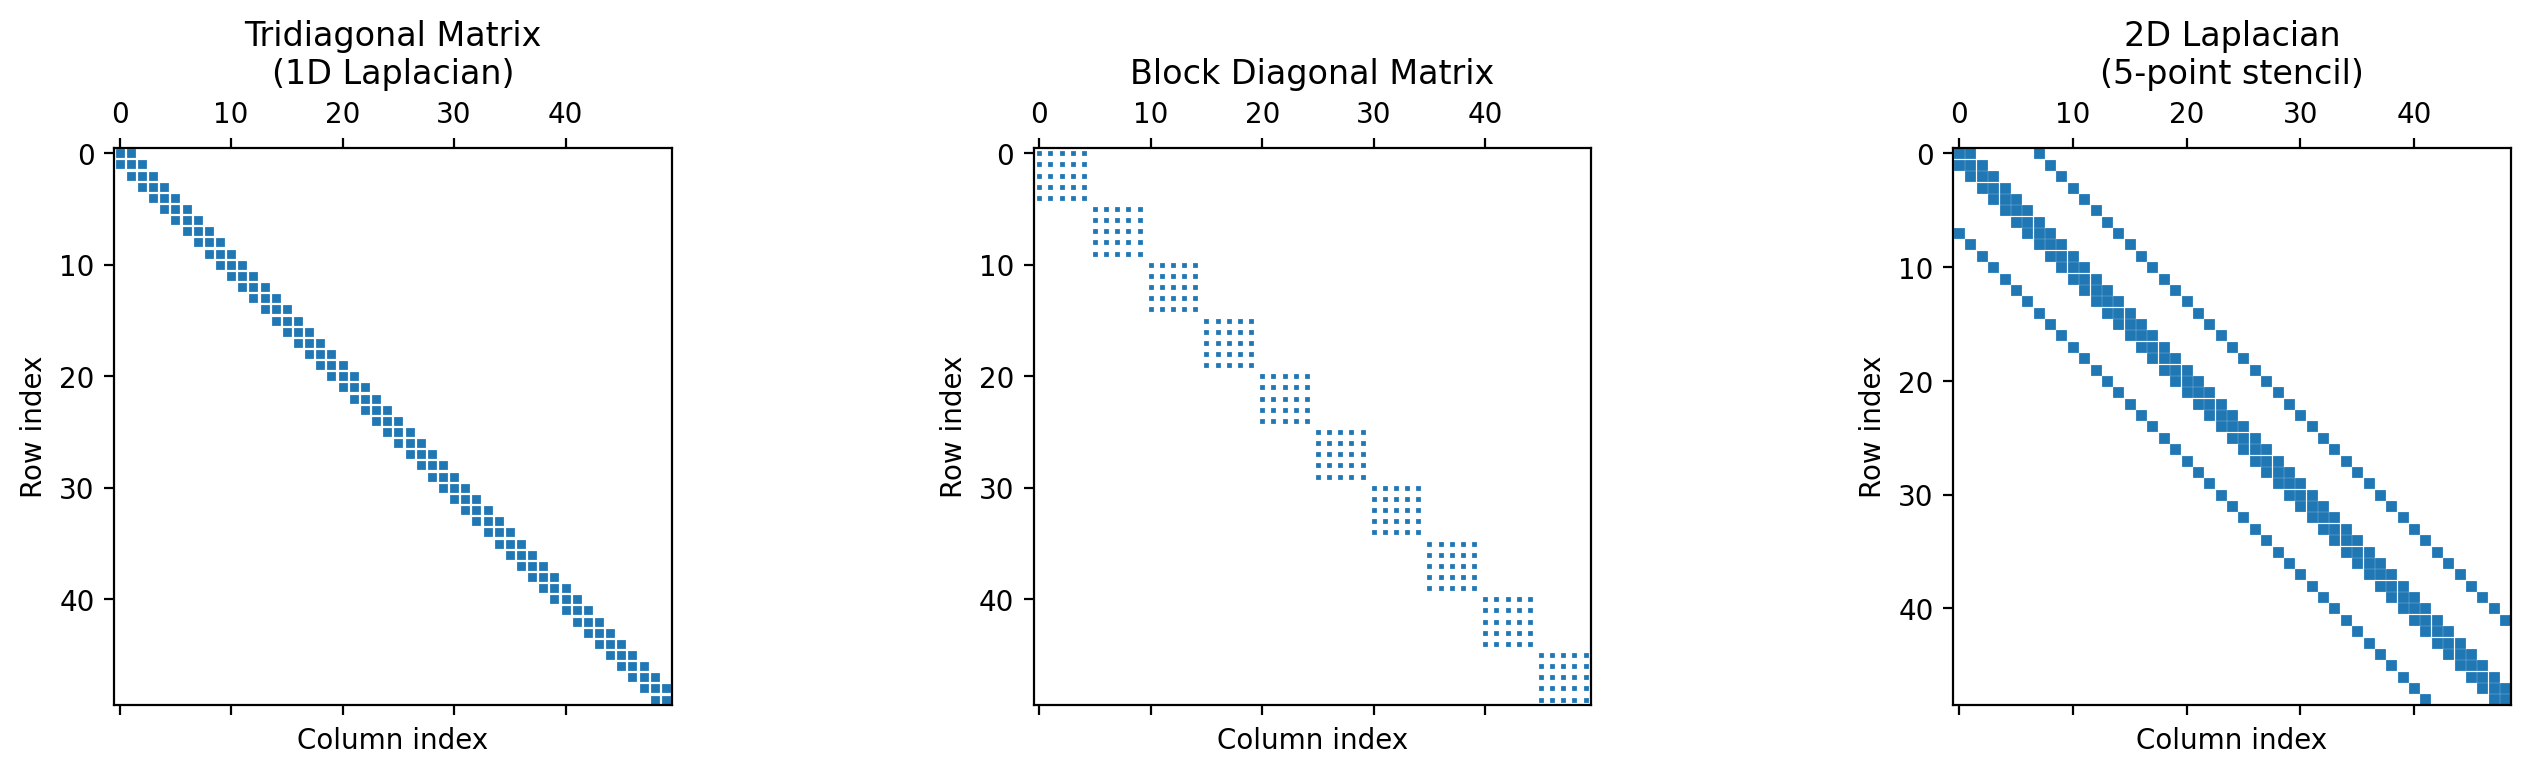

In [4]:
n = 50

# Tridiagonal matrix (1D Laplacian)
diagonals = [np.ones(n-1), -2*np.ones(n), np.ones(n-1)]
tridiag = sparse.diags(diagonals, [-1, 0, 1], format='csr')

# Block diagonal matrix
blocks = [np.random.randn(5, 5) for _ in range(10)]
block_diag = sparse.block_diag(blocks, format='csr')

# 2D Laplacian (5-point stencil)
n_2d = 7
laplacian_2d = sparse.diags(
    [1, 1, -4, 1, 1],
    [-n_2d, -1, 0, 1, n_2d],
    shape=(n_2d**2, n_2d**2),
    format='csr'
)

# Visualize sparsity patterns
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].spy(tridiag, markersize=2)
axes[0].set_title('Tridiagonal Matrix\n(1D Laplacian)')
axes[0].set_xlabel('Column index')
axes[0].set_ylabel('Row index')

axes[1].spy(block_diag, markersize=1)
axes[1].set_title('Block Diagonal Matrix')
axes[1].set_xlabel('Column index')
axes[1].set_ylabel('Row index')

axes[2].spy(laplacian_2d, markersize=3)
axes[2].set_title('2D Laplacian\n(5-point stencil)')
axes[2].set_xlabel('Column index')
axes[2].set_ylabel('Row index')

plt.tight_layout()
plt.savefig('sparsity_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

## Performance Comparison: Sparse vs Dense Operations

Let's benchmark the performance advantage of sparse matrix operations compared to their dense counterparts.

In [5]:
def benchmark_matvec(sizes, density=0.01, n_trials=5):
    """Benchmark matrix-vector multiplication for sparse and dense matrices."""
    results = {'size': [], 'sparse_time': [], 'dense_time': [], 'speedup': []}
    
    for n in sizes:
        # Create sparse matrix and vector
        A_sparse = sparse.random(n, n, density=density, format='csr')
        A_dense = A_sparse.toarray()
        x = np.random.randn(n)
        
        # Benchmark sparse multiplication
        start = time.perf_counter()
        for _ in range(n_trials):
            y_sparse = A_sparse @ x
        sparse_time = (time.perf_counter() - start) / n_trials
        
        # Benchmark dense multiplication
        start = time.perf_counter()
        for _ in range(n_trials):
            y_dense = A_dense @ x
        dense_time = (time.perf_counter() - start) / n_trials
        
        results['size'].append(n)
        results['sparse_time'].append(sparse_time * 1000)  # Convert to ms
        results['dense_time'].append(dense_time * 1000)
        results['speedup'].append(dense_time / sparse_time)
    
    return results

# Run benchmarks
sizes = [100, 500, 1000, 2000, 3000, 4000, 5000]
results = benchmark_matvec(sizes, density=0.01)

# Display results
print("Matrix-Vector Multiplication Benchmark (density=1%)\n")
print(f"{'Size':>6} {'Sparse (ms)':>12} {'Dense (ms)':>12} {'Speedup':>10}")
print("-" * 44)
for i in range(len(sizes)):
    print(f"{results['size'][i]:>6} {results['sparse_time'][i]:>12.3f} "
          f"{results['dense_time'][i]:>12.3f} {results['speedup'][i]:>10.1f}x")

Matrix-Vector Multiplication Benchmark (density=1%)

  Size  Sparse (ms)   Dense (ms)    Speedup
--------------------------------------------
   100        0.013        0.005        0.4x
   500        0.010        0.052        5.0x
  1000        0.020       27.910     1363.1x
  2000        0.054        7.492      138.8x
  3000        0.114       24.544      215.4x
  4000        0.160        9.250       57.9x
  5000        0.225       26.868      119.6x


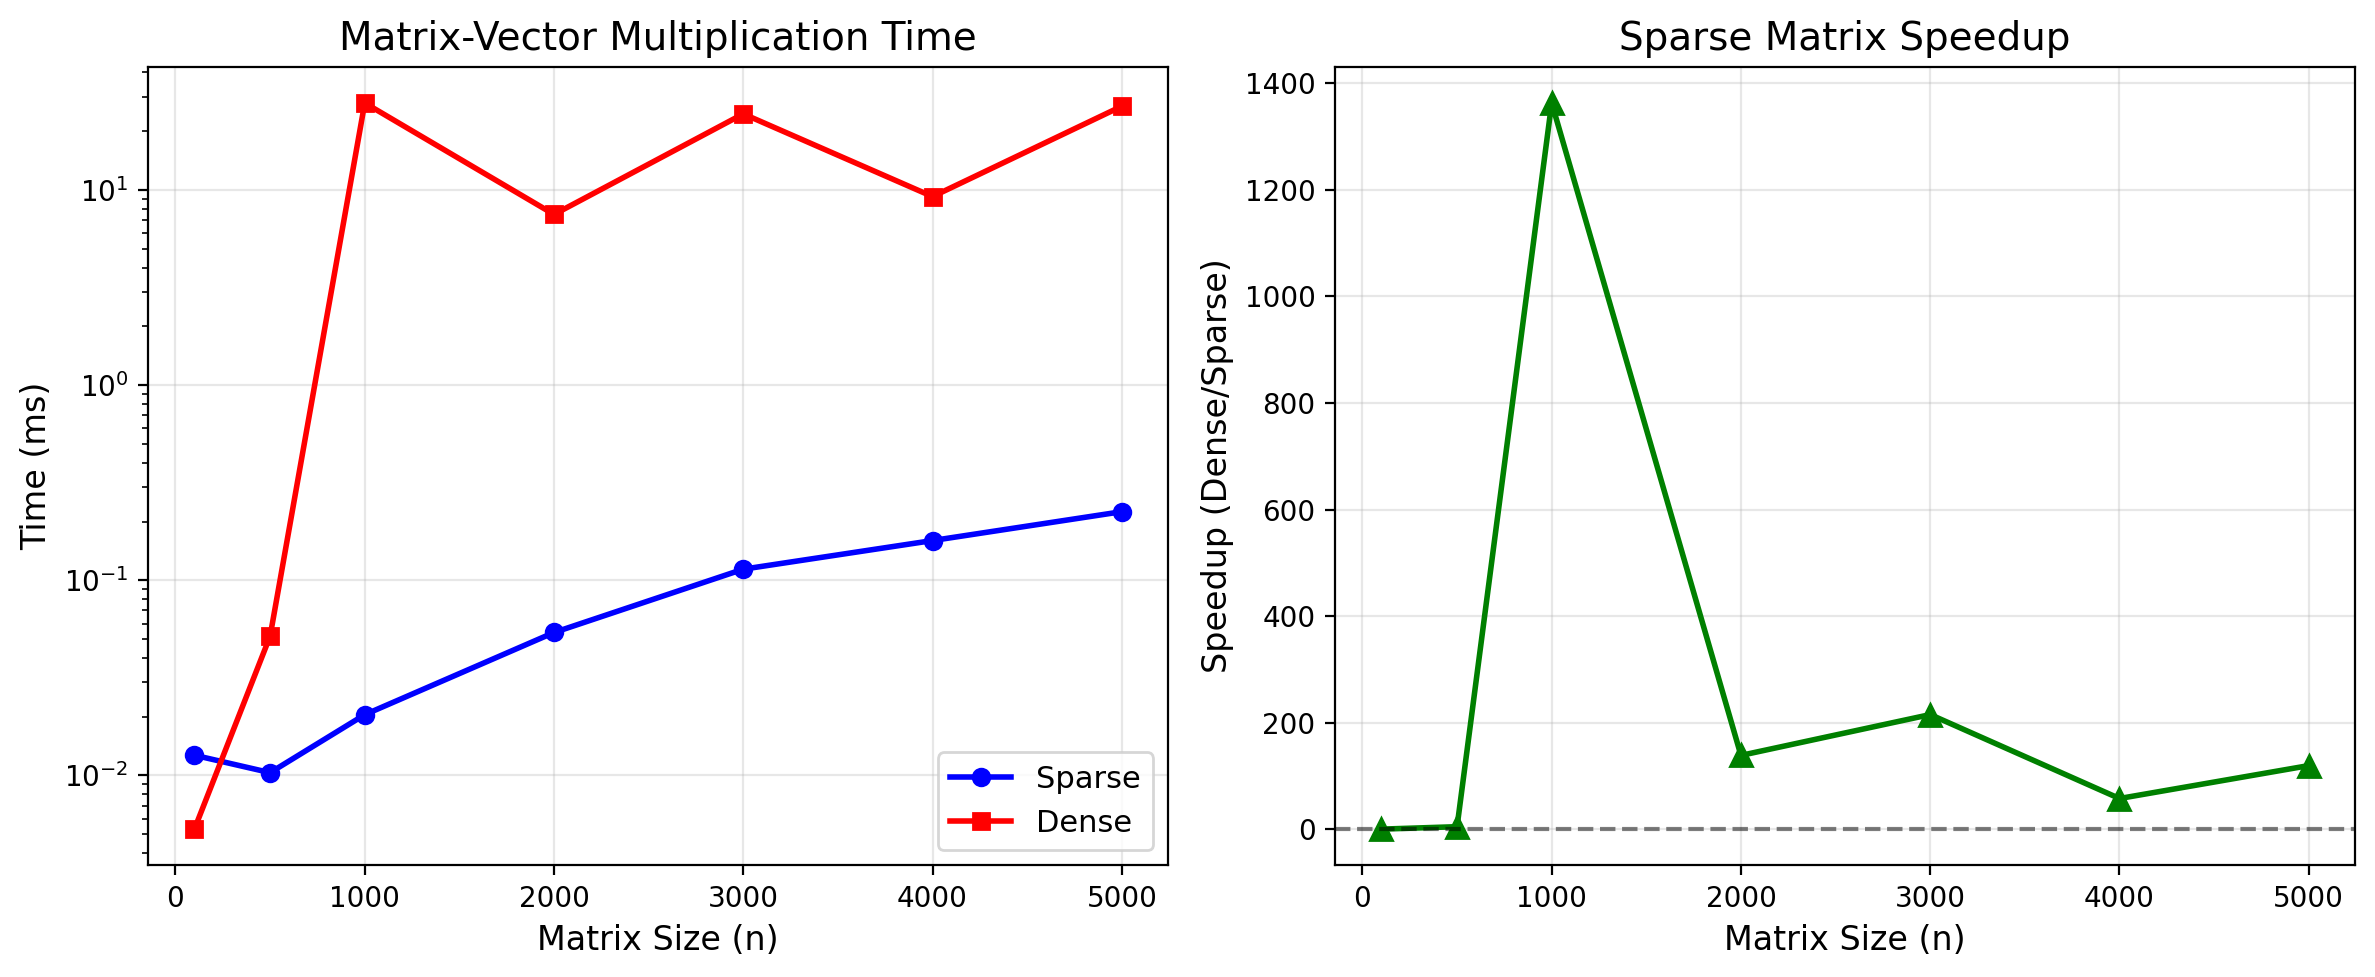

In [6]:
# Visualize benchmark results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Timing comparison
axes[0].plot(results['size'], results['sparse_time'], 'b-o', label='Sparse', linewidth=2)
axes[0].plot(results['size'], results['dense_time'], 'r-s', label='Dense', linewidth=2)
axes[0].set_xlabel('Matrix Size (n)', fontsize=12)
axes[0].set_ylabel('Time (ms)', fontsize=12)
axes[0].set_title('Matrix-Vector Multiplication Time', fontsize=14)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

# Speedup
axes[1].plot(results['size'], results['speedup'], 'g-^', linewidth=2, markersize=8)
axes[1].set_xlabel('Matrix Size (n)', fontsize=12)
axes[1].set_ylabel('Speedup (Dense/Sparse)', fontsize=12)
axes[1].set_title('Sparse Matrix Speedup', fontsize=14)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=1, color='k', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('benchmark_matvec.png', dpi=150, bbox_inches='tight')
plt.show()

## Solving Sparse Linear Systems

One of the most important applications of sparse matrices is solving large linear systems $\mathbf{A}\mathbf{x} = \mathbf{b}$.

In [7]:
def create_poisson_matrix(n):
    """Create a 2D Poisson equation discretization matrix."""
    # 5-point stencil for 2D Laplacian
    N = n * n
    main_diag = 4 * np.ones(N)
    side_diag = -np.ones(N - 1)
    far_diag = -np.ones(N - n)
    
    # Handle boundary conditions (remove connections at edges)
    for i in range(1, n):
        side_diag[i * n - 1] = 0
    
    diagonals = [far_diag, side_diag, main_diag, side_diag, far_diag]
    offsets = [-n, -1, 0, 1, n]
    
    return sparse.diags(diagonals, offsets, shape=(N, N), format='csr')

# Create test problem
n_grid = 50
A = create_poisson_matrix(n_grid)
N = n_grid ** 2

# Right-hand side (manufactured solution)
x_true = np.random.randn(N)
b = A @ x_true

print(f"Poisson system size: {N}x{N}")
print(f"Non-zeros: {A.nnz:,}")
print(f"Sparsity: {1 - A.nnz/(N*N):.4%}")

Poisson system size: 2500x2500
Non-zeros: 12,300
Sparsity: 99.8032%


In [8]:
# Compare different sparse solvers
solvers = {
    'Direct (spsolve)': lambda A, b: splinalg.spsolve(A, b),
    'Conjugate Gradient': lambda A, b: splinalg.cg(A, b, atol=1e-10)[0],
    'GMRES': lambda A, b: splinalg.gmres(A, b, atol=1e-10)[0],
    'BiCGSTAB': lambda A, b: splinalg.bicgstab(A, b, atol=1e-10)[0]
}

results_solvers = {}

print("Solver Comparison\n")
print(f"{'Solver':<25} {'Time (ms)':>12} {'Rel. Error':>15}")
print("-" * 55)

for name, solver in solvers.items():
    start = time.perf_counter()
    x_computed = solver(A, b)
    elapsed = (time.perf_counter() - start) * 1000
    
    rel_error = np.linalg.norm(x_computed - x_true) / np.linalg.norm(x_true)
    results_solvers[name] = {'time': elapsed, 'error': rel_error}
    
    print(f"{name:<25} {elapsed:>12.3f} {rel_error:>15.2e}")

Solver Comparison

Solver                       Time (ms)      Rel. Error
-------------------------------------------------------
Direct (spsolve)                 4.918        3.38e-15
Conjugate Gradient               3.011        3.51e-04
GMRES                           13.018        4.58e-03
BiCGSTAB                         4.266        5.53e-03


## Sparse Matrix Eigenvalue Problems

Computing eigenvalues of large sparse matrices is crucial in many applications. We'll use ARPACK via scipy's `eigsh` for symmetric matrices.

In [9]:
# Create a symmetric sparse matrix (graph Laplacian)
n = 500
density = 0.02

# Generate random symmetric sparse matrix
A_rand = sparse.random(n, n, density=density, format='csr')
A_sym = (A_rand + A_rand.T) / 2  # Make symmetric

# Add a small shift to diagonal to ensure matrix is positive definite
# This helps with convergence when finding smallest eigenvalues
A_sym = A_sym + sparse.eye(n) * 0.1

# Compute a few eigenvalues
k = 10  # Number of eigenvalues to compute

# Largest eigenvalues
start = time.perf_counter()
eigenvalues_large, eigenvectors_large = splinalg.eigsh(A_sym, k=k, which='LM')
time_large = time.perf_counter() - start

# Smallest eigenvalues - use shift-invert mode for better convergence
# sigma=0 transforms the problem to find eigenvalues near 0
start = time.perf_counter()
eigenvalues_small, eigenvectors_small = splinalg.eigsh(A_sym, k=k, which='LM', sigma=0)
time_small = time.perf_counter() - start

print(f"Eigenvalue computation for {n}x{n} matrix:\n")
print(f"Largest {k} eigenvalues (computed in {time_large*1000:.1f} ms):")
print(np.sort(eigenvalues_large)[::-1])
print(f"\nSmallest {k} eigenvalues (computed in {time_small*1000:.1f} ms):")
print(np.sort(eigenvalues_small))

Eigenvalue computation for 500x500 matrix:

Largest 10 eigenvalues (computed in 7.4 ms):
[ 5.41136637  2.71472952  2.6411916   2.61426533  2.57866653  2.56840762
  2.52630361  2.50578268 -2.5089088  -2.54053892]

Smallest 10 eigenvalues (computed in 37.2 ms):
[-0.02729208 -0.01946042 -0.01639844 -0.0123401  -0.00144571  0.00264946
  0.01146194  0.01494761  0.023271    0.02793893]


## Effect of Density on Performance

Let's systematically study how matrix density affects the performance of sparse operations.

In [10]:
def benchmark_density(n, densities, n_trials=3):
    """Benchmark sparse operations across different densities."""
    results = {
        'density': [],
        'matvec_time': [],
        'matmat_time': [],
        'memory': []
    }
    
    for density in densities:
        A = sparse.random(n, n, density=density, format='csr')
        x = np.random.randn(n)
        B = sparse.random(n, n, density=density, format='csr')
        
        # Matrix-vector multiplication
        start = time.perf_counter()
        for _ in range(n_trials):
            y = A @ x
        matvec_time = (time.perf_counter() - start) / n_trials * 1000
        
        # Matrix-matrix multiplication
        start = time.perf_counter()
        for _ in range(n_trials):
            C = A @ B
        matmat_time = (time.perf_counter() - start) / n_trials * 1000
        
        # Memory usage
        memory = (A.data.nbytes + A.indices.nbytes + A.indptr.nbytes) / 1024
        
        results['density'].append(density * 100)
        results['matvec_time'].append(matvec_time)
        results['matmat_time'].append(matmat_time)
        results['memory'].append(memory)
    
    return results

# Run density benchmark
n = 2000
densities = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2]
density_results = benchmark_density(n, densities)

print(f"Density Impact Benchmark (n={n})\n")
print(f"{'Density (%)':>12} {'Mat-Vec (ms)':>14} {'Mat-Mat (ms)':>14} {'Memory (KB)':>12}")
print("-" * 56)
for i in range(len(densities)):
    print(f"{density_results['density'][i]:>12.1f} {density_results['matvec_time'][i]:>14.2f} "
          f"{density_results['matmat_time'][i]:>14.2f} {density_results['memory'][i]:>12.1f}")

Density Impact Benchmark (n=2000)

 Density (%)   Mat-Vec (ms)   Mat-Mat (ms)  Memory (KB)
--------------------------------------------------------
         0.1           0.02           0.21         54.7
         0.5           0.04           1.44        242.2
         1.0           0.06           6.41        476.6
         2.0           0.09          38.33        945.3
         5.0           0.19         116.51       2351.6
        10.0           0.38         213.66       4695.3
        15.0           0.58         391.56       7039.1
        20.0           0.78         645.49       9382.8


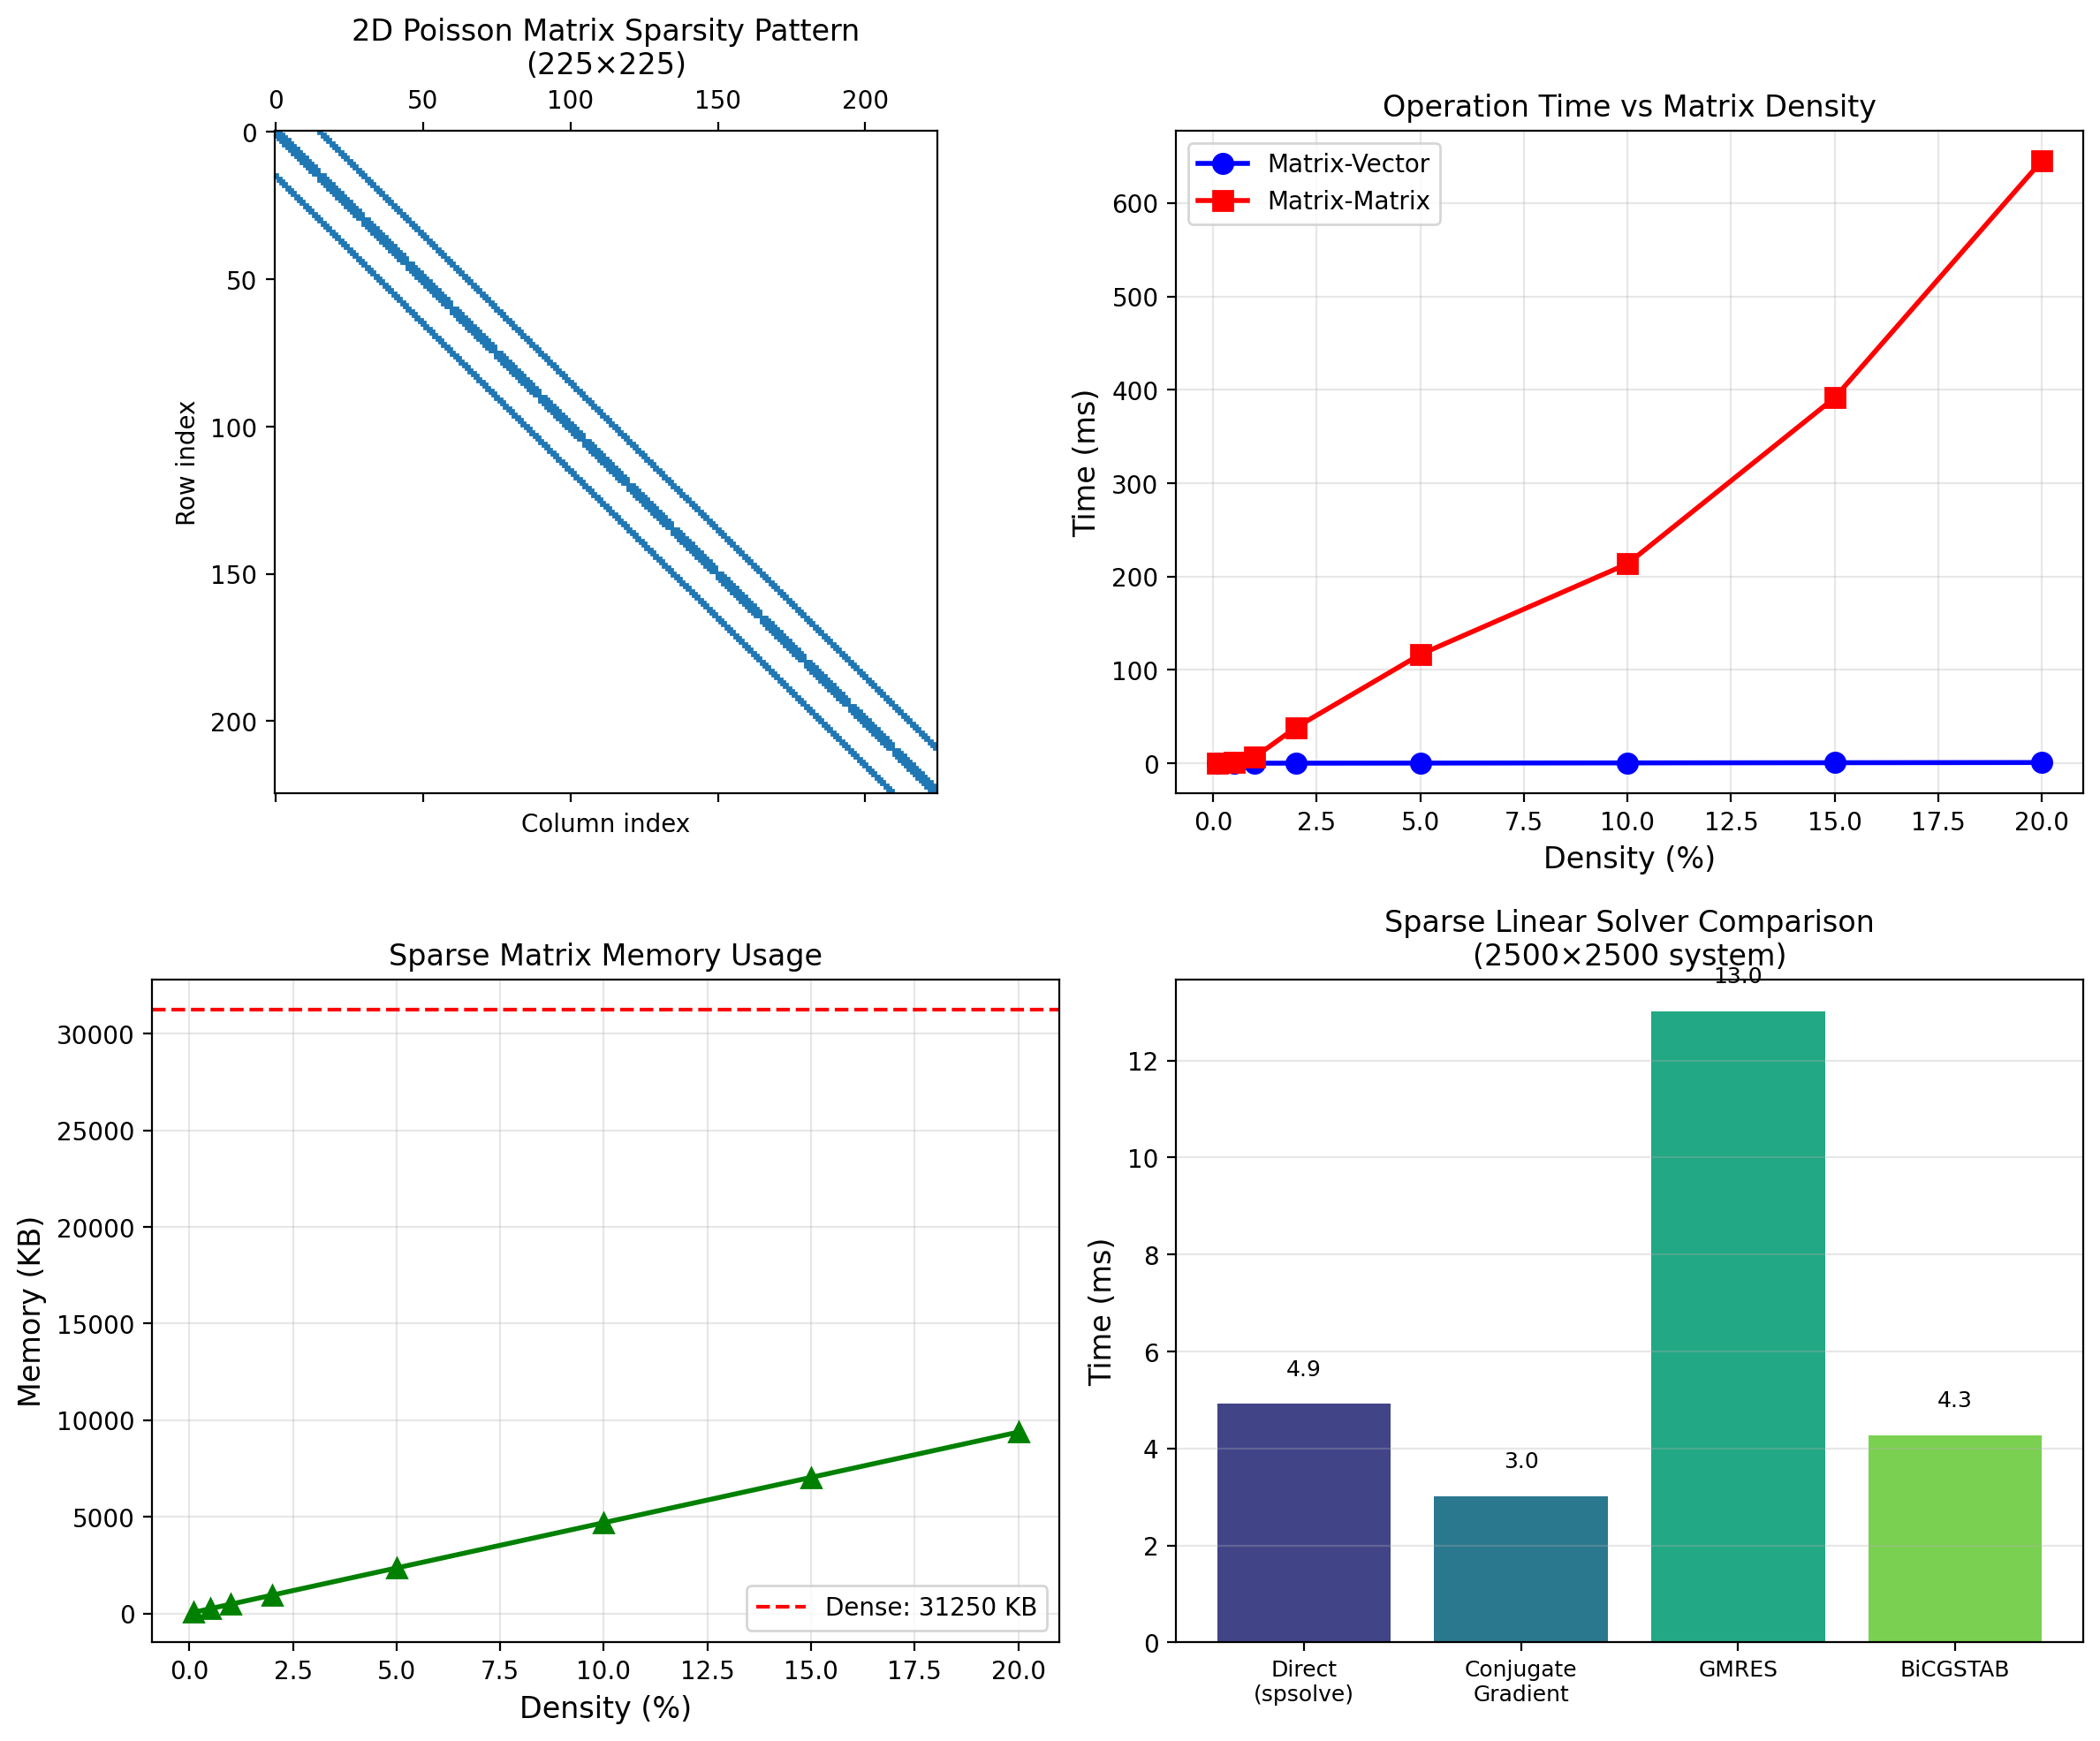


Final visualization saved to 'plot.png'


In [11]:
# Create final comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Sparsity pattern of 2D Laplacian
n_lap = 15
laplacian = create_poisson_matrix(n_lap)
axes[0, 0].spy(laplacian, markersize=1.5)
axes[0, 0].set_title(f'2D Poisson Matrix Sparsity Pattern\n({n_lap**2}×{n_lap**2})', fontsize=12)
axes[0, 0].set_xlabel('Column index')
axes[0, 0].set_ylabel('Row index')

# Plot 2: Performance vs density (Mat-Vec)
axes[0, 1].plot(density_results['density'], density_results['matvec_time'], 
                'b-o', linewidth=2, markersize=8, label='Matrix-Vector')
axes[0, 1].plot(density_results['density'], density_results['matmat_time'], 
                'r-s', linewidth=2, markersize=8, label='Matrix-Matrix')
axes[0, 1].set_xlabel('Density (%)', fontsize=12)
axes[0, 1].set_ylabel('Time (ms)', fontsize=12)
axes[0, 1].set_title('Operation Time vs Matrix Density', fontsize=12)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Memory usage vs density
axes[1, 0].plot(density_results['density'], density_results['memory'], 
                'g-^', linewidth=2, markersize=8)
dense_memory = n * n * 8 / 1024  # KB
axes[1, 0].axhline(y=dense_memory, color='r', linestyle='--', 
                   label=f'Dense: {dense_memory:.0f} KB')
axes[1, 0].set_xlabel('Density (%)', fontsize=12)
axes[1, 0].set_ylabel('Memory (KB)', fontsize=12)
axes[1, 0].set_title('Sparse Matrix Memory Usage', fontsize=12)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Solver comparison bar chart
solver_names = list(results_solvers.keys())
solver_times = [results_solvers[name]['time'] for name in solver_names]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(solver_names)))

bars = axes[1, 1].bar(range(len(solver_names)), solver_times, color=colors)
axes[1, 1].set_xticks(range(len(solver_names)))
axes[1, 1].set_xticklabels([name.replace(' ', '\n') for name in solver_names], fontsize=9)
axes[1, 1].set_ylabel('Time (ms)', fontsize=12)
axes[1, 1].set_title(f'Sparse Linear Solver Comparison\n({n_grid**2}×{n_grid**2} system)', fontsize=12)
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, time_val in zip(bars, solver_times):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{time_val:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('sparse_matrix_operations_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFinal visualization saved to 'plot.png'")

## Summary

### Key Takeaways

1. **Storage Efficiency**: Sparse matrix formats (CSR, CSC) achieve significant memory savings for matrices with low density. The compression ratio scales inversely with density.

2. **Computational Performance**: Sparse matrix-vector multiplication achieves $O(k)$ complexity versus $O(n^2)$ for dense matrices, where $k$ is the number of non-zeros.

3. **Solver Selection**: 
   - Direct solvers (`spsolve`) are robust but may be slower for very large systems
   - Iterative solvers (CG, GMRES, BiCGSTAB) scale better for large sparse systems
   - Conjugate Gradient is optimal for symmetric positive definite matrices

4. **Practical Guidelines**:
   - Use sparse formats when sparsity exceeds ~95%
   - Choose CSR for row operations, CSC for column operations
   - Profile your specific use case to select optimal solver

### Applications

Sparse matrix techniques are fundamental to:
- Finite element/difference methods for PDEs
- Large-scale optimization
- Graph algorithms (PageRank, community detection)
- Machine learning (sparse features, regularization)